# GMM with Model Selection

One of the features of Gaussian Mixture Models is [model selection](https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#sphx-glr-auto-examples-mixture-plot-gmm-selection-py). This is done by selecting the number of components and covariance structure that results in the best (lowest) BIC. This removes the need for the analyst to guess the number of clusters. We can instead let the clustering algorithm select the best number of clusters for us and instead focus on interpreting what the segments represent.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from cluster.cluster_functions import *
from cluster.plotting import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import pairwise_distances_argmin_min

# sns.set()
%load_ext autoreload
%autoreload 2

In [2]:
invoices = pd.read_csv("data/retail/invoices_2009_2011_no_returns.csv", low_memory=False)
invoices['InvoiceDate'] = pd.to_datetime(invoices['InvoiceDate'])
invoices.dropna(inplace=True)

In [3]:
cohort_customer_ids = invoices[invoices.InvoiceDate<'2010-12-1'].CustomerID.unique()
cohort_invoices = invoices[invoices.CustomerID.isin(cohort_customer_ids)]
cohort_invoices[cohort_invoices['CustomerID']==13087.0]  # Print transaction history for Customer 13087

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
26740,491711,85123,WHITE HANGING HEART T-LIGHT HOLDER,18,2009-12-13 15:16:00,2.95,13087.0,United Kingdom,53.10
26741,491711,21463,MIRRORED DISCO BALL,4,2009-12-13 15:16:00,5.95,13087.0,United Kingdom,23.80
26742,491711,85168,WHITE BAROQUE CARRIAGE CLOCK,4,2009-12-13 15:16:00,9.95,13087.0,United Kingdom,39.80
26743,491711,84765,SILVER ROCOCO CANDELABRA,2,2009-12-13 15:16:00,12.75,13087.0,United Kingdom,25.50
26744,491711,22215,CAKE STAND WHITE TWO TIER LACE,2,2009-12-13 15:16:00,8.50,13087.0,United Kingdom,17.00
26745,491711,84750,BLACK SMALL GLASS CAKE STAND,8,2009-12-13 15:16:00,1.95,13087.0,United Kingdom,15.60
26746,491711,22183,CAKE STAND VICTORIAN FILIGREE MED,3,2009-12-13 15:16:00,6.75,13087.0,United Kingdom,20.25
26747,491711,35637,IVORY STRING CURTAIN WITH POLE,2,2009-12-13 15:16:00,5.95,13087.0,United Kingdom,11.90
26748,491711,84707,PINK JEWELLED MIRROR TRINKET TRAY,2,2009-12-13 15:16:00,9.95,13087.0,United Kingdom,19.90
26749,491711,84709,PINK OVAL JEWELLED MIRROR,3,2009-12-13 15:16:00,5.95,13087.0,United Kingdom,17.85


<br>
<br>

In [4]:
features = get_money_aggregation_features(cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_time_aggregation_features(features, cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_rfm_features(features, cohort_invoices[cohort_invoices.InvoiceDate<'2010-12-1'])
features = get_second_year_rlv(features, cohort_invoices[cohort_invoices.InvoiceDate>='2010-12-1'])
features.head()

,CustomerID,MedianPurchaseValue,StDevPurchaseValue,MinPurchaseValue,MaxPurchaseValue,SumPurchaseValue,SizePurchaseValue,MedianTimeBetweenPurchase,StDevTimeBetweenPurchase,MinTimeBetweenPurchase,MaxTimeBetweenPurchase,frequency,recency,T,monetary_value,T_Minus_Recency,SecondYearRLV
0,12356.0,798.44,840.956062,349.85,1977.96,3126.25,3,21.5,13.435029,12.0,31.0,2.0,44.0,50.0,1163.905,155.0,2487.43
1,12358.0,821.08,581.088065,268.10,1429.83,2519.01,3,177.5,4.949747,174.0,181.0,2.0,356.0,357.0,544.590,30.0,928.06
2,12359.0,417.70,231.086670,78.20,760.69,2563.36,6,81.0,45.850845,11.0,110.0,5.0,309.0,360.0,360.534,64.0,6372.58
3,12360.0,502.04,291.890867,118.00,690.79,1310.83,3,131.5,55.861436,92.0,171.0,2.0,263.0,281.0,596.415,33.0,2302.06
4,12361.0,94.20,8.127782,83.15,99.00,276.35,3,109.5,9.192388,103.0,116.0,2.0,220.0,308.0,91.075,1.0,174.90


In [5]:
features_to_transform = [
    'MedianPurchaseValue', # 'MeanPurchaseValue', 
    'StDevPurchaseValue',
    'MinPurchaseValue', 
    'MaxPurchaseValue', 
    'SumPurchaseValue',
    'SizePurchaseValue',
    'MedianTimeBetweenPurchase',
    'StDevTimeBetweenPurchase',
    'MinTimeBetweenPurchase',
    'MaxTimeBetweenPurchase',
#     'T_Minus_Recency'
]
features, transformed_feature_names, yjt = transform_features(features, features_to_transform, transform="yjt")
features.head()

,yjt_MedianPurchaseValue,yjt_StDevPurchaseValue,yjt_MinPurchaseValue,yjt_MaxPurchaseValue,yjt_SumPurchaseValue,yjt_SizePurchaseValue,yjt_MedianTimeBetweenPurchase,yjt_StDevTimeBetweenPurchase,yjt_MinTimeBetweenPurchase,yjt_MaxTimeBetweenPurchase,CustomerID,frequency,recency,T,monetary_value,T_Minus_Recency,SecondYearRLV
0,5.789114,5.365618,15.644784,3.224589,3.705797,0.706056,4.810429,3.379806,3.223952,7.144626,12356.0,2.0,44.0,50.0,1163.905,155.0,2487.43
1,5.809899,5.132718,14.216121,3.181008,3.669940,0.706056,11.021725,2.083714,8.320107,16.214547,12358.0,2.0,356.0,357.0,544.590,30.0,928.06
2,5.300495,4.525551,8.895903,3.084534,3.672903,0.794942,8.287425,5.433585,3.100379,13.005773,12359.0,5.0,309.0,360.0,360.534,64.0,6372.58
3,5.440558,4.682928,10.459276,3.068304,3.550225,0.706056,9.907941,5.812600,6.863877,15.816835,12360.0,2.0,263.0,281.0,596.415,33.0,2302.06
4,4.127572,2.048027,9.117004,2.634365,3.182981,0.706056,9.270728,2.847447,7.109999,13.319642,12361.0,2.0,220.0,308.0,91.075,1.0,174.90


In [6]:
cluster_feature_names = transformed_feature_names
scaler = StandardScaler()
cluster_features = features[cluster_feature_names].copy()
cluster_features = scaler.fit_transform(cluster_features)
cluster_features = pd.DataFrame(cluster_features, columns=cluster_feature_names)

Let the GMM find the best number of components and covariance structure to use

Cluster labels - 0 = Low value customer, 5 = High value customer
Silhouette Coefficient:0.15795010907982265
Median 2nd year RLV: [ 444.74  1937.8   3226.1   1138.995  910.68  1131.88 ]
Differences: [1493.06, 1288.3, 2087.11, 228.31, 221.2]
Value Counts:
0    497
1     72
2    399
3    198
4    416
5    317
Name: Cluster, dtype: int64
Explained variance ratio: [0.41830064 0.2769082 ]
Total explained variance: 0.6952088410642028


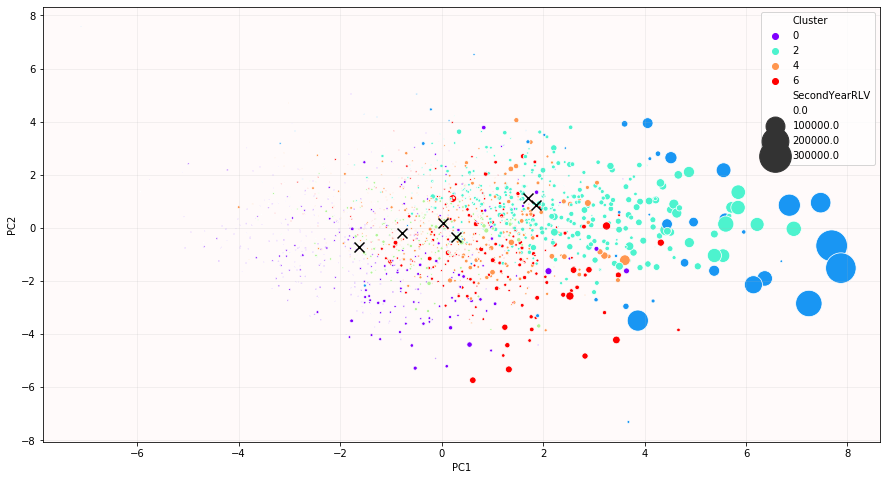

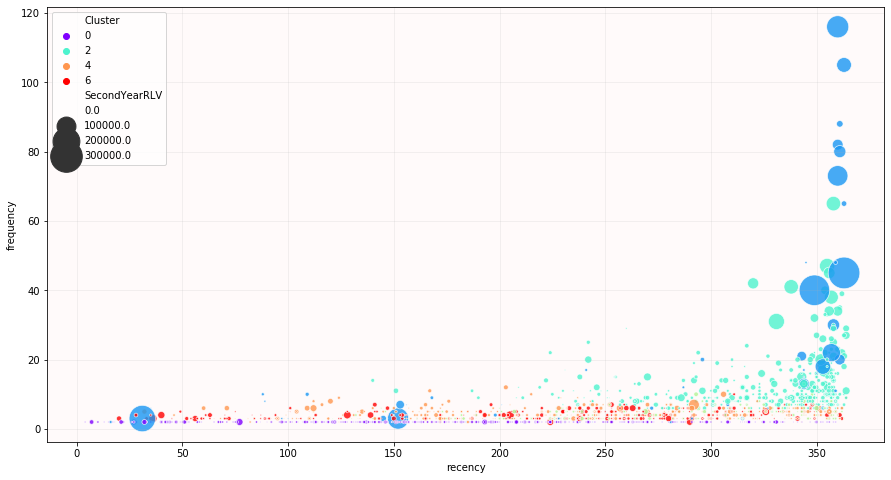

In [7]:
best_gmm = select_best_gmm(cluster_features, state=3)
cluster_features['Cluster'] = best_gmm.predict(cluster_features)
cluster_centers = best_gmm.means_
num_clusters = best_gmm.n_components
cluster_features['SecondYearRLV'] = features['SecondYearRLV']
evaluate_clusters(cluster_features, num_clusters)
pca = cluster_pca_plot(cluster_features, cluster_centers, scaled=True)
cluster_rf_plot(cluster_features, features)

In [8]:
# Print component loadings
pd.DataFrame(
    data=pca.components_,
    columns=features_to_transform,
    index=['Component 1', 'Component 2']
)

,MedianPurchaseValue,StDevPurchaseValue,MinPurchaseValue,MaxPurchaseValue,SumPurchaseValue,SizePurchaseValue,MedianTimeBetweenPurchase,StDevTimeBetweenPurchase,MinTimeBetweenPurchase,MaxTimeBetweenPurchase
Component 1,0.297597,0.337401,0.069660,0.389678,0.446685,0.344361,-0.330561,-0.238875,-0.280295,-0.279081
Component 2,-0.415640,-0.252700,-0.411593,-0.327157,-0.168908,0.228350,-0.365923,-0.260104,-0.308154,-0.331299


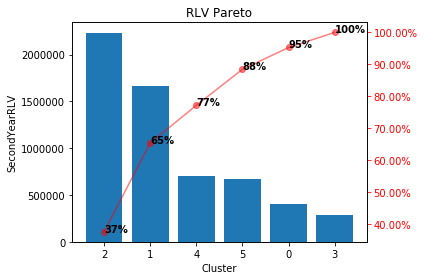

In [9]:
df = cluster_features.groupby('Cluster')['SecondYearRLV'].sum().reset_index()
df['Cluster'] = df['Cluster'].astype(str)
pareto_plot(df, x='Cluster', y='SecondYearRLV', show_pct_y=True, title='RLV Pareto')

**Mean Cluster features**

In [10]:
features_copy = features.copy()

# Inverse transform to see cluster features
if yjt:
    features_copy.drop(columns=transformed_feature_names, inplace=True)
    features_copy = pd.concat([
        pd.DataFrame(yjt.inverse_transform(features[transformed_feature_names]), columns=features_to_transform),
        features_copy
    ], axis=1)
    features_copy['Cluster'] = cluster_features['Cluster'].values 
else:
    for transf_col, col in zip(transformed_feature_names, features_to_transform):
        features_copy[transf_col] = np.exp(features_copy[transf_col]) - 1
        features_copy.rename(columns={transf_col:col}, inplace=True)
    features_copy['Cluster'] = cluster_features['Cluster'].values 
features_copy.groupby("Cluster").mean().sort_values(by='SecondYearRLV')

,MedianPurchaseValue,StDevPurchaseValue,MinPurchaseValue,MaxPurchaseValue,SumPurchaseValue,SizePurchaseValue,MedianTimeBetweenPurchase,StDevTimeBetweenPurchase,MinTimeBetweenPurchase,MaxTimeBetweenPurchase,CustomerID,frequency,recency,T,monetary_value,T_Minus_Recency,SecondYearRLV
Cluster,,,,,,,,,,,,,,,,,
0,364.214306,168.966984,240.754366,562.387485,1167.356157,3.000000,90.203219,53.771416,52.181087,128.225352,15254.102616,2.000000,181.390342,245.830986,387.220885,82.227364,819.256740
3,341.026313,85.511403,251.787273,459.959495,1856.813081,5.313131,60.323232,45.788950,25.560606,122.515152,15702.318182,4.313131,273.090909,309.944444,348.486436,82.636364,1425.891465
4,351.661923,229.236673,132.219567,709.959111,2107.848341,5.451923,45.776442,56.301492,10.663462,129.600962,15378.629808,4.451923,239.237981,279.391827,370.518415,85.586538,1686.973582
5,476.458470,221.719137,287.891199,832.249148,2536.212145,4.971609,54.533123,22.332750,34.826498,82.012618,15192.331230,3.971609,215.993691,263.678233,496.086995,90.362776,2124.827729
2,415.225702,255.243667,154.776992,1057.184386,6898.345489,13.345865,27.377193,21.597660,6.704261,72.824561,15257.546366,12.345865,319.729323,338.571429,461.269765,82.907268,5597.843810
1,896.152361,1594.229380,173.696250,5224.541806,24748.571528,18.097222,29.791667,22.814543,14.805556,67.013889,15626.083333,17.097222,223.208333,279.958333,1306.130009,94.736111,23065.141389


# Discussion

Cluster 1 and Cluster 2 together contain 25% of the total customer base for this cohort but resulted in 65% of the total second year revenue. These are your most valuable customers. 

**What do the clusters represent?**

Listed in order from highest to lowest second year Residual Lifetime Value:

- Cluster 1 - Customers in this segment have the **largest purchase value** day to day transactions. Each purchase day is over double the value compared to customers from every other segment. They also **purchase most often**. They are not the longest term customers. 
- Cluster 2 - Customers in this segment purchase **very often**. Approximately 3x more often than customers in segments other than cluster 1. They are also the **longest term** customers.
- Cluster 5 - Customers in this segment have a **higher than average purchase value**
- Cluster 3/4 - These clusters are not very distinguishable from purchasing behaviour alone. Day to day transactions are of similar purchase value.
- Cluster 0 - Customers in this segment purchase **least often** and have the **shortest lifespan**. They are most likely either very new customers or inactive customers who are no longer purchasing from the store. 